In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import os
import random
import shutil

def split_by_patient(dataset_root, target_root, train_ratio, val_ratio):
    if not os.path.exists(target_root):
        # create target root if not exit
        os.makedirs(target_root)

        # AFF and NFF folder
        fracture_types = ['AFF', 'NFF']

        for fracture_type in fracture_types:
            source_folder = os.path.join(dataset_root, fracture_type)
            patients = os.listdir(source_folder)
            
            # select random patients
            random.seed(123)
            random.shuffle(patients)
            
            # split patients
            total_patients = len(patients)
            train_end = int(total_patients * train_ratio)
            val_end = train_end + int(total_patients * val_ratio)
            
            train_patients = patients[:train_end]
            val_patients = patients[train_end:val_end]
            test_patients = patients[val_end:]
            
            # copy images to folder
            for patient_id in train_patients:
                source_path = os.path.join(source_folder, patient_id)
                target_path = os.path.join(target_root, 'train', fracture_type, patient_id)
                shutil.copytree(source_path, target_path)
            
            for patient_id in val_patients:
                source_path = os.path.join(source_folder, patient_id)
                target_path = os.path.join(target_root, 'val', fracture_type, patient_id)
                shutil.copytree(source_path, target_path)
            
            for patient_id in test_patients:
                source_path = os.path.join(source_folder, patient_id)
                target_path = os.path.join(target_root, 'test', fracture_type, patient_id)
                shutil.copytree(source_path, target_path)
        print("Dataset split completed.")
    
    else:
        print("Target dataset folder already exists.")

def create_dataset(train_root, val_root, test_root):
    # Define data augmentation transforms
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=.5),
        transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.2)], p=.5),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Define the data loaders
    train_dataset = ImageFolder(root=train_root, transform=train_transform)
    validation_dataset = ImageFolder(root=val_root, transform=test_transform)
    test_dataset = ImageFolder(root=test_root, transform=test_transform)

    return train_dataset, validation_dataset, test_dataset

def show_image(dataset, num_images=5):
    # Get some random indices from the dataset
    random_indices = np.random.choice(len(dataset), num_images, replace=False)

    # Plot images with truncated names
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]  # Use the dataset directly
        filename = dataset.samples[idx][0]  # Get the filename
        truncated_filename = filename.split('/')[-1][:15]  # Extract the last part and truncate to 15 characters
        plt.subplot(1, num_images, i + 1)
        plt.title(f"Label: {label}")
        # plt.imshow(image[0], cmap='gray')  # Assuming single-channel (grayscale) image
        plt.imshow(image[0])  # Assuming single-channel (grayscale) image
        plt.axis('off')
    plt.show()

def get_classweight(train_dataset):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # aff and nff numbers in training dataset
    train_aff_count = sum(1 for _, label in train_dataset if label == 0)  # 0 AFF
    train_nff_count = sum(1 for _, label in train_dataset if label == 1)  # 1 NFF

    # Calculate class weights
    n_aff_train = train_aff_count
    n_nff_train = train_nff_count

    class_weight_aff = 1 / (2 * (n_aff_train / (n_aff_train + n_nff_train)))
    class_weight_nff = 1 / (2 * (n_nff_train / (n_aff_train + n_nff_train)))
    
    return [class_weight_aff, class_weight_nff]
    
    
    
def train_model(train_loader, validation_loader, classweight, num_epochs, lr, step_size, gamma, model_name, device):

    # Load pre-trained model
    torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')
    if model_name == 'resnet152':
        from torchvision.models import resnet152, ResNet152_Weights
        model = models.resnet152(weights=ResNet152_Weights.DEFAULT)
        
    elif model_name == 'densenet161':
        from torchvision.models import densenet161, DenseNet161_Weights
        model = models.densenet161(weights=DenseNet161_Weights.DEFAULT)
        
    elif model_name == 'resnet50':
        from torchvision.models import resnet50, ResNet50_Weights
        model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

    elif model_name == 'vgg19':
        from torchvision.models import vgg19, VGG19_Weights
        model = models.vgg19(weights=VGG19_Weights.DEFAULT)

    elif model_name == 'resnet101':
        from torchvision.models import resnet101, ResNet101_Weights
        model = models.resnet101(weights=ResNet101_Weights.DEFAULT)
        
    else:
        raise ValueError("Invalid model type. 'vgg19' 'resnet50' 'resnet101' 'resnet152' or 'densenet161'.")
    
    # Modify the output layer
    num_classes = 2
    if model_name == 'densenet161':
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)
    else:
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    
    # Move model to the specified device
    model = model.to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss(weight=torch.Tensor(classweight).to(device))
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    
    # Training (loss and accuracy)
    train_losses = []
    validation_losses = []
    train_accuracies = []
    validation_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_accuracy = 100 * correct_train / total_train
        
        model.eval()
        correct_validation = 0
        total_validation = 0
        validation_loss = 0
        
        with torch.no_grad():
            for images, labels in validation_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total_validation += labels.size(0)
                correct_validation += (predicted == labels).sum().item()
                validation_loss += loss.item()
        
        # validation accuracy and loss
        validation_accuracy = 100 * correct_validation / total_validation
        validation_loss /= len(validation_loader)
        
        train_losses.append(loss.item())
        validation_losses.append(validation_loss)
        train_accuracies.append(train_accuracy)
        validation_accuracies.append(validation_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
            f"Train Loss: {loss.item():.4f}, "
            f"Validation Loss: {validation_loss:.4f}, "
            f"Train Acc: {train_accuracy:.2f}%, "
            f"Validation Acc: {validation_accuracy:.2f}%")
        
        scheduler.step()  # Step the learning rate scheduler

    # Plot loss and accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(validation_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend() 

    plt.show()

    return model


def test_model(model, test_dataset, batch_size, device):
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    
    model.eval()
    correct_test = 0
    total_test = 0
    test_loss = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            test_loss += loss.item()

    test_accuracy = 100 * correct_test / total_test
    test_loss /= len(test_loader)

    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

    original_classes = test_loader.dataset.classes

    # confusion matrix
    with torch.no_grad():
        all_predictions = []
        all_labels = []

        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # Precision、Recall、F1 Score
    classification_rep = classification_report(all_labels, all_predictions, target_names=original_classes)

    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(classification_rep)


Target dataset folder already exists.


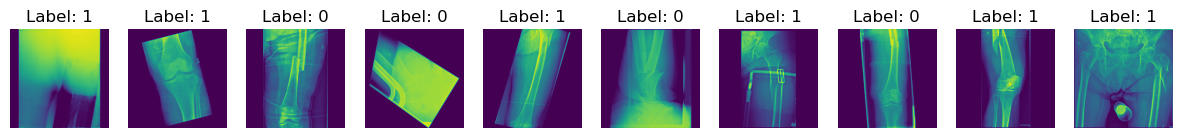

[2.53728813559322, 0.622712146422629]


In [3]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# create train val and test folder
dataset_root = '/local/data1/honzh073/data/patient_level'
target_root = '/local/data1/honzh073/data/patient_level_dataset'

split_by_patient(dataset_root, target_root, train_ratio=0.7, val_ratio=0.2)

# create dataset
train_root = '/local/data1/honzh073/data/patient_level_dataset/train'
val_root = '/local/data1/honzh073/data/patient_level_dataset/val'
test_root='/local/data1/honzh073/data/patient_level_dataset/test'
train_dataset, validation_dataset, test_dataset = create_dataset(train_root, val_root, test_root)

# show image
show_image(validation_dataset, 10)

# load data
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# classweight
classweight = get_classweight(train_dataset)
# classweight = [2.53728813559322, 0.622712146422629]
print(classweight)

Epoch 1/50, Train Loss: 0.5447, Validation Loss: 0.5992, Train Acc: 64.23%, Validation Acc: 68.90%
Epoch 2/50, Train Loss: 0.3062, Validation Loss: 0.4045, Train Acc: 74.85%, Validation Acc: 81.76%
Epoch 3/50, Train Loss: 0.2519, Validation Loss: 0.3465, Train Acc: 83.67%, Validation Acc: 86.26%
Epoch 4/50, Train Loss: 0.1555, Validation Loss: 0.2644, Train Acc: 87.84%, Validation Acc: 88.68%
Epoch 5/50, Train Loss: 0.2564, Validation Loss: 0.2598, Train Acc: 90.38%, Validation Acc: 88.90%
Epoch 6/50, Train Loss: 0.2994, Validation Loss: 0.2496, Train Acc: 91.35%, Validation Acc: 89.01%
Epoch 7/50, Train Loss: 0.3013, Validation Loss: 0.2350, Train Acc: 92.38%, Validation Acc: 90.66%
Epoch 8/50, Train Loss: 0.2974, Validation Loss: 0.2306, Train Acc: 92.28%, Validation Acc: 90.44%
Epoch 9/50, Train Loss: 0.4186, Validation Loss: 0.2449, Train Acc: 93.89%, Validation Acc: 90.33%
Epoch 10/50, Train Loss: 0.4071, Validation Loss: 0.2706, Train Acc: 93.55%, Validation Acc: 89.23%
Epoch 11/

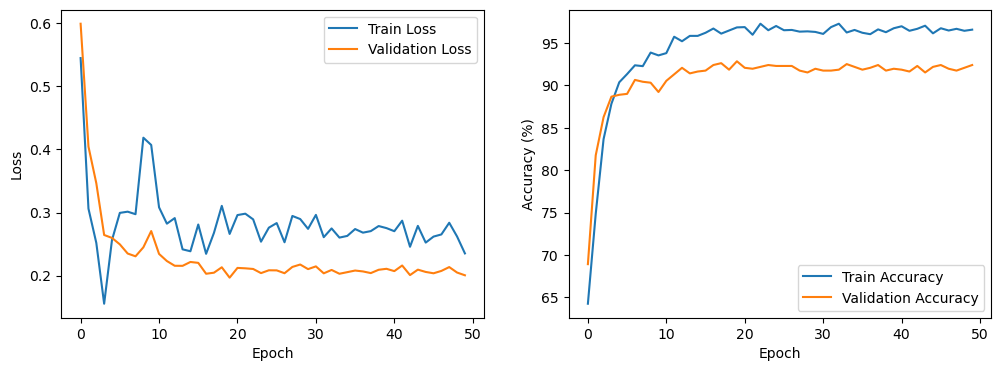

Test Loss: 0.2067, Test Acc: 93.15%
Confusion Matrix:
[[ 91  10]
 [ 20 317]]
Classification Report:
              precision    recall  f1-score   support

         AFF       0.82      0.90      0.86       101
         NFF       0.97      0.94      0.95       337

    accuracy                           0.93       438
   macro avg       0.89      0.92      0.91       438
weighted avg       0.93      0.93      0.93       438



In [3]:
# resnet50
resnet50 = train_model(train_loader, validation_loader,
                       classweight=classweight,
                       num_epochs=50, 
                       lr=0.0001, step_size=10, gamma=0.1, 
                       model_name='resnet50')
test_model(resnet50, test_loader)

Epoch 1/50, Train Loss: 0.3523, Validation Loss: 0.4953, Train Acc: 63.66%, Validation Acc: 76.81%
Epoch 2/50, Train Loss: 0.1367, Validation Loss: 0.3235, Train Acc: 78.56%, Validation Acc: 85.27%
Epoch 3/50, Train Loss: 0.1238, Validation Loss: 0.2893, Train Acc: 86.87%, Validation Acc: 89.12%
Epoch 4/50, Train Loss: 0.1943, Validation Loss: 0.2927, Train Acc: 89.35%, Validation Acc: 87.03%
Epoch 5/50, Train Loss: 0.1081, Validation Loss: 0.2137, Train Acc: 90.01%, Validation Acc: 91.43%
Epoch 6/50, Train Loss: 0.1452, Validation Loss: 0.2019, Train Acc: 92.05%, Validation Acc: 91.32%
Epoch 7/50, Train Loss: 0.2423, Validation Loss: 0.2244, Train Acc: 93.89%, Validation Acc: 89.56%
Epoch 8/50, Train Loss: 0.2054, Validation Loss: 0.2185, Train Acc: 93.62%, Validation Acc: 91.43%
Epoch 9/50, Train Loss: 0.0320, Validation Loss: 0.2233, Train Acc: 94.02%, Validation Acc: 90.55%
Epoch 10/50, Train Loss: 0.0044, Validation Loss: 0.1786, Train Acc: 94.79%, Validation Acc: 93.74%
Epoch 11/

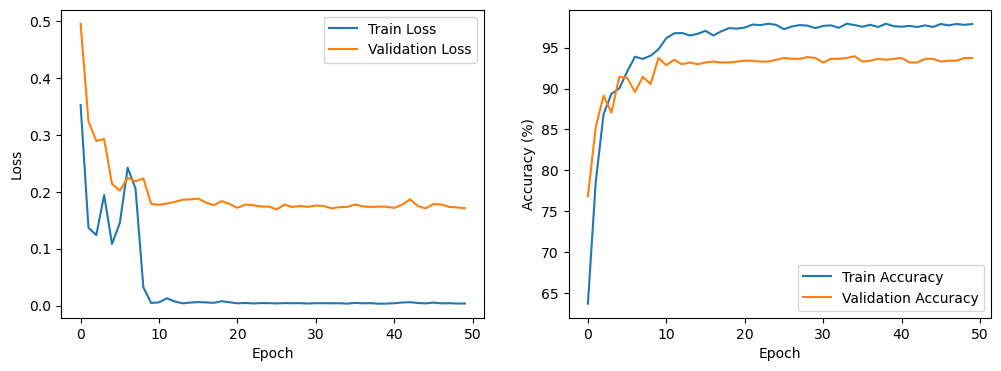

Test Loss: 0.2321, Test Acc: 93.61%
Confusion Matrix:
[[ 94   7]
 [ 21 316]]
Classification Report:
              precision    recall  f1-score   support

         AFF       0.82      0.93      0.87       101
         NFF       0.98      0.94      0.96       337

    accuracy                           0.94       438
   macro avg       0.90      0.93      0.91       438
weighted avg       0.94      0.94      0.94       438



In [5]:
# resnet101
resnet101 = train_model(train_loader, validation_loader, classweight, num_epochs=50, lr=0.0001, step_size=10, gamma=0.1, model_name='resnet101')
test_model(resnet101, test_loader)

Epoch 1/50, Train Loss: 0.3063, Validation Loss: 0.4515, Train Acc: 66.97%, Validation Acc: 80.66%
Epoch 2/50, Train Loss: 0.1550, Validation Loss: 0.3245, Train Acc: 79.89%, Validation Acc: 85.93%
Epoch 3/50, Train Loss: 0.0904, Validation Loss: 0.2541, Train Acc: 87.04%, Validation Acc: 89.12%
Epoch 4/50, Train Loss: 0.1683, Validation Loss: 0.2184, Train Acc: 89.91%, Validation Acc: 91.65%
Epoch 5/50, Train Loss: 0.2356, Validation Loss: 0.2673, Train Acc: 91.05%, Validation Acc: 87.25%
Epoch 6/50, Train Loss: 0.1000, Validation Loss: 0.2128, Train Acc: 94.15%, Validation Acc: 88.68%
Epoch 7/50, Train Loss: 0.2338, Validation Loss: 0.1977, Train Acc: 94.79%, Validation Acc: 91.76%
Epoch 8/50, Train Loss: 0.1445, Validation Loss: 0.2031, Train Acc: 95.09%, Validation Acc: 93.52%
Epoch 9/50, Train Loss: 0.3761, Validation Loss: 0.2611, Train Acc: 95.99%, Validation Acc: 89.89%
Epoch 10/50, Train Loss: 0.2050, Validation Loss: 0.1633, Train Acc: 94.46%, Validation Acc: 93.52%
Epoch 11/

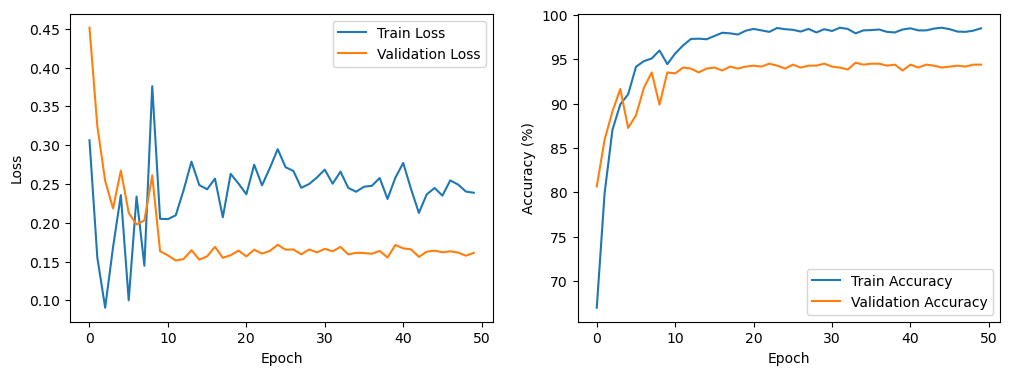

Test Loss: 0.2321, Test Acc: 93.61%
Confusion Matrix:
[[ 94   7]
 [ 21 316]]
Classification Report:
              precision    recall  f1-score   support

         AFF       0.82      0.93      0.87       101
         NFF       0.98      0.94      0.96       337

    accuracy                           0.94       438
   macro avg       0.90      0.93      0.91       438
weighted avg       0.94      0.94      0.94       438



In [6]:
# resnet152
resnet152 = train_model(train_loader, validation_loader, classweight, num_epochs=50, lr=0.0001, step_size=10, gamma=0.1, model_name='resnet152')
test_model(resnet101, test_loader)

In [1]:
# densenet161
densenet161 = train_model(train_loader, validation_loader, classweight, num_epochs=50, lr=0.0001, step_size=10, gamma=0.1, model_name='densenet161', device=device)
test_model(densenet161, test_loader, device=device)

NameError: name 'train_model' is not defined